<a href="https://colab.research.google.com/github/sergiosb99/SSJ_SupervisedLearning/blob/Novelty/Dengue_Upgrade_Outliers_DBSCAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#  **0. Introduction**


We will use the data from the competition to predict the evolution of Dengue Disease in both Iquitos and San Juan. More information in [link](https://www.drivendata.org/competitions/44/dengai-predicting-disease-spread/)

The objective of the exercise is to solve a regression problem and on the other hand to participate in a data competition.


# **1. Libraries**

Before starting any analysis we must ensure that the basic and general use libraries (numpy, pandas, etc.) are correctly imported. 

In [ ]:
# Loading the data
import pandas as pd
import io
from google.colab import files

# Graphics display
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

# Estimator and model selection
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

# Others
import numpy as np    
from sklearn.metrics import mean_absolute_error

from sklearn.neighbors import kneighbors_graph
import numpy
import sklearn.neighbors



# **2. Loading the data**

The first step is to upload all the CSV files that have been provided to us and that thanks to them we will obtain the data with which we are going to work. To do this, we will use the tools that Google Colab offers us when uploading files.

## Preprocessing the data

We transform the data in order to allow us the posterior use of the algorithms to build prediction models, for example, missing values, from categories to numbers, etc.

We first load the datasets, and merge them in one, named train.

In [ ]:
train_feat = pd.read_csv('dengue_features_train.csv')

In [ ]:
train_labels = pd.read_csv('dengue_labels_train.csv')

In [ ]:
train = pd.merge(train_feat,train_labels,on=['city','year','weekofyear'])

We upload the test dataset in order to know how good our model is.

In [ ]:
test = pd.read_csv('dengue_features_test.csv')

We fill the Nan values:

In [ ]:
train.fillna(method='ffill', inplace=True)
test.fillna(method='ffill', inplace=True)

In [ ]:
train

,city,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,reanalysis_max_air_temp_k,reanalysis_min_air_temp_k,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,total_cases
0,sj,1990,18,1990-04-30,0.122600,0.103725,0.198483,0.177617,12.42,297.572857,297.742857,292.414286,299.8,295.9,32.00,73.365714,12.42,14.012857,2.628571,25.442857,6.900000,29.4,20.0,16.0,4
1,sj,1990,19,1990-05-07,0.169900,0.142175,0.162357,0.155486,22.82,298.211429,298.442857,293.951429,300.9,296.4,17.94,77.368571,22.82,15.372857,2.371429,26.714286,6.371429,31.7,22.2,8.6,5
2,sj,1990,20,1990-05-14,0.032250,0.172967,0.157200,0.170843,34.54,298.781429,298.878571,295.434286,300.5,297.3,26.10,82.052857,34.54,16.848571,2.300000,26.714286,6.485714,32.2,22.8,41.4,4
3,sj,1990,21,1990-05-21,0.128633,0.245067,0.227557,0.235886,15.36,298.987143,299.228571,295.310000,301.4,297.0,13.90,80.337143,15.36,16.672857,2.428571,27.471429,6.771429,33.3,23.3,4.0,3
4,sj,1990,22,1990-05-28,0.196200,0.262200,0.251200,0.247340,7.52,299.518571,299.664286,295.821429,301.9,297.5,12.20,80.460000,7.52,17.210000,3.014286,28.942857,9.371429,35.0,23.9,5.8,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1451,iq,2010,21,2010-05-28,0.342750,0.318900,0.256343,0.292514,55.30,299.334286,300.771429,296.825714,309.7,294.5,45.00,88.765714,55.30,18.485714,9.800000,28.633333,11.933333,35.4,22.4,27.0,5
1452,iq,2010,22,2010-06-04,0.160157,0.160371,0.136043,0.225657,86.47,298.330000,299.392857,296.452857,308.5,291.9,207.10,91.600000,86.47,18.070000,7.471429,27.433333,10.500000,34.7,21.7,36.6,8
1453,iq,2010,23,2010-06-11,0.247057,0.146057,0.250357,0.233714,58.94,296.598571,297.592857,295.501429,305.5,292.4,50.60,94.280000,58.94,17.008571,7.500000,24.400000,6.900000,32.2,19.2,7.4,1
1454,iq,2010,24,2010-06-18,0.333914,0.245771,0.278886,0.325486,59.67,296.345714,297.521429,295.324286,306.1,291.9,62.33,94.660000,59.67,16.815714,7.871429,25.433333,8.733333,31.2,21.0,16.0,1



We are going to select this features for our training:

In [ ]:
selected_features = ['reanalysis_specific_humidity_g_per_kg', 'reanalysis_dew_point_temp_k', 
                 'station_avg_temp_c', 'station_min_temp_c']

Now we are going to know which sample is an outlier:

In [ ]:
train_df = train[selected_features]
train_df['total_cases'] = train['total_cases']

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



We apply the PCA, first by normalizing the data:

In [ ]:
from sklearn import preprocessing 
scaler = preprocessing.MinMaxScaler()
datanorm = scaler.fit_transform(train_df)

We use 2 components and apply the PCA.

In [ ]:
#2. PCA Estimation
from sklearn.decomposition import PCA
estimator = PCA (n_components = 2)
X_pca = estimator.fit_transform(datanorm)

In [ ]:
print(estimator.explained_variance_ratio_) 

[0.76264458 0.10877373]


With this, we can now look for outliers, using DBSCAN.

We obtain first the similarity matrix to see how the data is.

In [ ]:

dist = sklearn.neighbors.DistanceMetric.get_metric('euclidean')
matsim = dist.pairwise(datanorm)

#fig = px.imshow(matsim)
#fig.show()

Now we compute the distance from each point to its neigbours:

In [ ]:
minPts=3

A = kneighbors_graph(datanorm, minPts, include_self=False)
Ar = A.toarray()

seq = []
for i,s in enumerate(datanorm):
    for j in range(len(datanorm)):
        if Ar[i][j] != 0:
            seq.append(matsim[i][j])
            
seq.sort()

In [ ]:
fig = px.line(x=np.arange(0, len(seq), 1), y=seq)
fig.show()

We try differnt clusters from the interval 0.02 to 0.12, with intervals of 0.1:

In [32]:
from sklearn.cluster import DBSCAN

results = []
for eps in numpy.arange(0.02, 0.12, 0.01):
  db = DBSCAN(eps, min_samples=minPts).fit(datanorm)
  core_samples_mask = numpy.zeros_like(db.labels_, dtype=bool)
  core_samples_mask[db.core_sample_indices_] = True
  labels = db.labels_
  n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
  n_outliers = list(labels).count(-1)
  #print ("%6.2f, %d, %d" % (eps, n_clusters_, n_outliers))
  results.append([eps, n_clusters_, n_outliers])

#print results
from tabulate import tabulate
print(tabulate(results, headers = ("eps", "clusters", "outliers")))

  eps    clusters    outliers
-----  ----------  ----------
 0.02          26        1363
 0.03          96         945
 0.04          80         564
 0.05          24         348
 0.06          13         213
 0.07          13         146
 0.08           5         108
 0.09           5          76
 0.1            4          57
 0.11           3          45


We select eps=0.06, obtaining 13 clusters and 213 outliers.

In [33]:
db = DBSCAN(eps=0.06, min_samples=minPts).fit(datanorm)
labels = db.labels_
labels

array([-1,  0,  0, ..., -1, -1,  0])

We label with 0 for no outlier and 1 for outlier in our dataset.

In [34]:
df_outliers = pd.DataFrame(columns=train_df.columns)
contador = 0
for item in labels:
    if item == -1:
        df_outliers = df_outliers.append(train_df.loc[contador],ignore_index=True)
        train_df.drop(contador,axis=0,inplace=True)
    contador+=1
df_outliers

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,reanalysis_specific_humidity_g_per_kg,reanalysis_dew_point_temp_k,station_avg_temp_c,station_min_temp_c,total_cases
0,14.012857,292.414286,25.442857,20.0,4.0
1,16.161429,294.782857,25.985714,22.2,52.0
2,13.615714,292.004286,24.685714,19.4,47.0
3,13.511429,291.907143,24.385714,18.9,21.0
4,13.878571,292.382857,24.714286,18.3,34.0
...,...,...,...,...,...
208,19.345714,297.568571,27.000000,22.9,12.0
209,20.461429,298.450000,30.000000,22.0,16.0
210,20.078571,298.161429,29.200000,22.5,9.0
211,17.008571,295.501429,24.400000,19.2,1.0


# **3. Detaching the dataset**

To train the models that we make, it is necessary to separate our training dataset into two parts, one precisely to train the model, and another to check if our models are good.

In this case, we are going to use two models, one for the average samples (no outliers) and for the outliers.

In [35]:
X_train_avg, X_test_avg, y_train_avg, y_test_avg = train_test_split(train_df.drop(columns=['total_cases'],axis=1), train_df['total_cases'], test_size=0.2, random_state=1) #falta el target

In [36]:
X_train_out, X_test_out, y_train_out, y_test_out = train_test_split(df_outliers.drop(columns=['total_cases'],axis=1), df_outliers['total_cases'], test_size=0.2, random_state=1)

# **4. Execution of the algorithm**

This algorithm is a set of Decision Trees, where each tree at the end of its execution will offer a result, at the end of all trees, the result will be the average of all the results.

In [37]:
def RandomForest(X_train, X_test,y_train,y_test,n_e,m_depth,title):
    #1.1 Model Parametrization 
    regressor = RandomForestRegressor(n_estimators= 100, max_depth = 5, criterion='mae', random_state=0)
    #1.2 Model construction
    regressor.fit(X_train, y_train)
    # Test
    y_pred = regressor.predict(X_test)
    mae = mean_absolute_error(y_test,y_pred)
    print ("Error Measure ",  mae, "\n")
    xx = np.stack(i for i in range(len(y_test)))
    plt.scatter(xx, y_test, c='r', label='data')
    plt.plot(xx, y_pred, c='g', label='prediction')
    plt.axis('tight')
    plt.legend()
    plt.title(title)

    plt.show()
    return regressor

We run the algorithm with de data which is not an outlier:

Error Measure  11.66222891566265 



/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2882: FutureWarning:

arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.



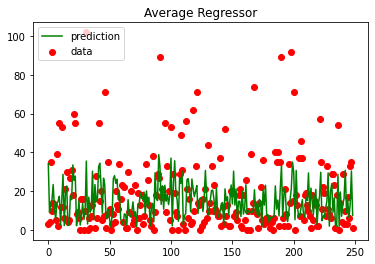

In [38]:
model_avg = RandomForest(X_train_avg, X_test_avg,y_train_avg,y_test_avg,100,5,"Average Regressor")

We run the algorithm with the data which is an outlier:

Error Measure  51.780348837209296 



/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2882: FutureWarning:

arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.



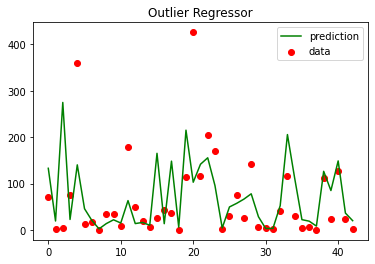

In [62]:
model_out = RandomForest(X_train_out,X_test_out,y_train_out,y_test_out,100,5,"Outlier Regressor")

# **Submission result**

Now, we are going to test our model with the data provided to us in the dengue_features_test.csv file to predict dengue cases for the weeks proposed in said file.

As we have two models, we have to predict two times, so the test dataset must be splitted in two, depending on if it is an outlier or not. To know that, we are going to apply the DBSCAN algorithm with the test dataset.


In [41]:
test_df = test[selected_features]

In [42]:
from sklearn import preprocessing 
scaler = preprocessing.MinMaxScaler()
datanorm_test = scaler.fit_transform(test_df)

In [43]:
#2. PCA Estimation
from sklearn.decomposition import PCA
estimator = PCA (n_components = 2)
X_pca = estimator.fit_transform(datanorm_test)

In [44]:
print(estimator.explained_variance_ratio_) 

[0.83432621 0.09784398]


In [48]:
dist = sklearn.neighbors.DistanceMetric.get_metric('euclidean')
matsim = dist.pairwise(datanorm_test)

In [49]:
minPts=3

A = kneighbors_graph(datanorm_test, minPts, include_self=False)
Ar = A.toarray()

seq = []
for i,s in enumerate(datanorm_test):
    for j in range(len(datanorm_test)):
        if Ar[i][j] != 0:
            seq.append(matsim[i][j])
            
seq.sort()

In [50]:
fig = px.line(x=np.arange(0, len(seq), 1), y=seq)
fig.show()

In [51]:
from sklearn.cluster import DBSCAN

results = []
for eps in numpy.arange(0.02, 0.12, 0.01):
  db = DBSCAN(eps, min_samples=minPts).fit(datanorm_test)
  core_samples_mask = numpy.zeros_like(db.labels_, dtype=bool)
  core_samples_mask[db.core_sample_indices_] = True
  labels = db.labels_
  n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
  n_outliers = list(labels).count(-1)
  #print ("%6.2f, %d, %d" % (eps, n_clusters_, n_outliers))
  results.append([eps, n_clusters_, n_outliers])

#print results
from tabulate import tabulate
print(tabulate(results, headers = ("eps", "clusters", "outliers")))

  eps    clusters    outliers
-----  ----------  ----------
 0.02           6         398
 0.03          15         368
 0.04          25         313
 0.05          40         179
 0.06          12         105
 0.07           7          62
 0.08           3          43
 0.09           3          32
 0.1            3          23
 0.11           2          16


In [52]:
db = DBSCAN(eps=0.06, min_samples=minPts).fit(datanorm_test)
labels = db.labels_
labels

array([ 0,  0, -1, -1,  1, -1,  2,  2,  2,  2,  2, -1,  2,  2,  2,  2,  2,
        2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  0,  3,  0,  0,
        3,  3,  3,  0,  0,  0,  0,  0,  3,  3,  0, -1,  4,  3,  4,  0, -1,
        5, -1,  0,  0,  0,  2,  2,  2,  2, -1,  6, -1, -1,  2,  2,  2,  2,
        2, -1, -1,  2,  2,  2,  2,  2,  2,  2,  2, -1,  2,  2,  2,  2,  2,
        8,  0,  0,  0, -1, -1,  0,  3,  0,  0,  0,  2, -1,  0, -1,  1,  5,
        0,  0,  2,  2,  2,  2, -1,  7,  2,  2,  2,  2,  2, -1,  2,  2,  2,
        2,  7,  2,  2,  2,  7,  2,  2,  2,  7,  2,  2, -1,  2,  0,  0, -1,
       -1,  0, -1,  0, -1, -1, -1, -1, -1,  0,  0, -1,  4,  3, -1,  3, -1,
        0,  0,  0, -1,  0, -1, -1, -1, -1, -1, -1,  2,  2,  2,  2,  2,  7,
        2, -1,  2,  7,  2,  2,  2, -1,  2,  2,  2,  2,  2,  2,  2,  2,  2,
       -1,  0,  0,  0,  0,  0, -1,  0,  3,  3, -1,  0,  3,  0,  0,  0, -1,
        0,  0,  0,  0,  0,  2,  0,  2,  2,  1, -1,  6,  6, -1, -1,  2,  2,
        2,  2,  2,  2,  2

In [54]:
df_outliers = pd.DataFrame(columns=test_df.columns)
contador = 0
for item in labels:
    if item == -1:
        df_outliers = df_outliers.append(test_df.loc[contador],ignore_index=True)
        test_df.drop(contador,axis=0,inplace=True)
    contador+=1
df_outliers

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,reanalysis_specific_humidity_g_per_kg,reanalysis_dew_point_temp_k,station_avg_temp_c,station_min_temp_c
0,16.674286,295.308571,27.928571,22.8
1,15.775714,294.402857,28.057143,24.4
2,16.667143,295.314286,28.000000,25.0
3,17.571429,296.177143,28.785714,26.1
4,13.668571,292.012857,25.500000,21.7
...,...,...,...,...
100,16.788571,295.275714,26.450000,21.2
101,17.618571,296.045714,26.700000,23.2
102,19.377143,297.562857,27.900000,22.8
103,14.852857,293.228571,27.250000,18.2


In [55]:
train_df = train[selected_features]

In [56]:
out_test = pd.DataFrame(columns=train_df.columns)
avg_test = pd.DataFrame(columns=train_df.columns)
contador = 0
for item in labels:
    if item == -1:
        out_test = out_test.append(train_df.loc[contador],ignore_index=True)
    else:
        avg_test = avg_test.append(train_df.loc[contador],ignore_index=True)
    contador+=1

Cases which are not outliers:

In [60]:
final_model_prediction_avg = model_avg.predict(avg_test)

Cases which are outliers:

In [63]:
final_model_prediction_out = model_out.predict(out_test)

We put together both results in order to obtain the final result:

In [64]:
final_model_prediction = np.array([])
contador_avg = 0
contador_out = 0
for item in labels:
    if item == -1:
        final_model_prediction = np.append(final_model_prediction,final_model_prediction_out[contador_out])
        contador_out+=1
    else:
        final_model_prediction = np.append(final_model_prediction,final_model_prediction_avg[contador_avg])
        contador_avg+=1

Finally we try to visualize how our prediction has turned out with reality.

In [66]:
# round the result and cast to int
y = np.rint(final_model_prediction) # round
y = y.astype(int) # cast to int
res = np.hstack(y)

res

array([ 14,   9, 107, 121,  16, 287,  12,  11,  11,  23,   7, 143,   9,
        11,  20,  12,  22,  29,  19,  28,  23,  21,  20,  33,  29,  11,
        14,  27,   7,  11,  18,  18,  14,  17,  13,  14,  16,  16,  15,
        17,  14,  14,  14,  15,  15,  28,  13,  16,  15,  16,  34,   8,
       122,  11,  11,  10,  14,  13,  24,  20, 152,  20, 283, 126,  22,
        22,  21,  20,  21, 139, 115,  17,  33,  26,  27,  11,  19,  16,
        22, 199,  11,   9,  11,  25,  16,  15,  15,  15,  15,  62,  40,
        18,  16,  17,  16,  15,  15,  40,  15,  60,  13,   7,  12,   9,
        11,   9,  10,  15, 159,  13,  23,  21,  20,  20,  20, 180,  14,
        11,  20,  12,  21,  22,  20,  23,  21,  27,  24,  19,  19,  26,
        17, 151,   9,  11,  24, 121,  91,   8,  38,  16,  54,  38,  40,
        34,  22,  15,   6,  31,  14,  14,  35,  10,  66,   4,   8,  16,
       145,  10,  90, 162,  97, 150,  46, 250,  10,  20,  20,   7,  16,
         8,  24, 108,  19,  18,  19,  19,  18, 140,  23,  22,  2

We build the output file


In [67]:
submission = pd.read_csv("submission_format.csv",
                         index_col=[0, 1, 2])


submission.total_cases = final_model_prediction.astype(np.int64)
submission.to_csv("result.csv")

**And the result is:**

28.8990
Woo! I scored 28.8990 on 'DengAI: Predicting Disease Spread'!